# Intertidal greenness mapping

Plan:
- Use approaches outlined in Intertidal_WIT.ipynb workflow to offer insights to intertidal areas without pre-requisite mapped habitat polygons
- Test various aquatic vegetation indices for suitability (improvements upon NDVI?)

In [25]:
## Import modules
import sys
sys.path.append("../Scripts")

import datacube
import xarray as xr

from dea_datahandling import load_ard
from dea_dask import create_local_dask_cluster
from CP_dea_plotting import display_map, rgb
from dea_coastaltools import tidal_stats, tidal_tag


In [9]:
## Connect to the datacube
dc = datacube.Datacube(app="Analyse_multiple_polygons")
create_local_dask_cluster()

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


Client Scheduler: tcp://127.0.0.1:37103 Dashboard: /user/cp/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 125.85 GB


In [95]:
## Set up the query
products = ["ga_ls5t_ard_3",
            "ga_ls7e_ard_3",
            "ga_ls8c_ard_3",
#             'item'
#             'nidem',
            'item_v2',
#             'item_v2_conf'
           ]
align = (0, 0)


# Query
query = {
    "x": (151.50609, 151.59366), 
    "y": (-24.00269, -24.12740), 
    "time": ("2019-01-01", "2021-01-01"),
    "measurements": ["nbart_red", "nbart_green", "nbart_blue", "nbart_nir", "nbart_swir_1"],
    "output_crs": "EPSG:3577", 
    "resolution": (-25, 25), # Collection 2 resolution used to match ITEM v2 resolution
    "group_by": "solar_day",
    "dask_chunks": {"time": 1, "x": 3000, "y": 3000},
}

display_map(x=query["x"], y=query['y'])

# # Dictionary to save results
# results = {}

In [158]:
## Load satellite imagery 

# Load landsat
ds = load_ard(
    dc=dc,
    products=products,
    min_gooddata=0.90,  # only take uncloudy scenes
    ls7_slc_off=False,
    skip_broken_datasets=True, ## New line 25/02/2021 TEMP fix while lingering ARD issue sorted
    **query,
)

## Tidally tag datasets
ds, tidepost_lon, tidepost_lat = tidal_tag(ds,
#                                            tideposts[-1],
                                           return_tideposts=True,
                                           ebb_flow=True)

# # Generate a polygon mask to keep only data within the polygon
# mask = xr_rasterize(gdf.iloc[[index]], ds)

# # Mask dataset to set pixels outside the polygon to `NaN`
# ds = ds.where(mask)

## Filter data by tide height, keeping only images exposing maximum intertidal area
# lowest_10 = ds.tide_height.quantile([0.10]).values
lowest_20 = ds.tide_height.quantile([0.20]).values  
ds1 = ds.where(ds.tide_height <= lowest_20, drop=True)

../Scripts/dea_datahandling.py:238: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
    item_v2
Counting good quality pixels for each time step
Filtering to 17 out of 58 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Returning 17 time steps as a dask array
Setting tide modelling location from dataset centroid: 151.55, -24.07
Modelling tidal phase (e.g. ebb or flow)


In [97]:
## Load ITEM, Note: ITEM layer is called 'relative'. TODO: rename for clarity

query2 = {
    "x": (151.50609, 151.59366), 
    "y": (-24.00269, -24.12740), 
}

# Load landsat
ds_item = dc.load(
#     dc=dc,
    product='item_v2',
    **query2
)
# ds_item

<xarray.Dataset>
Dimensions:      (time: 1, x: 434, y: 607)
Coordinates:
  * time         (time) datetime64[ns] 2001-06-01T23:59:59.500000
  * y            (y) float64 -2.74e+06 -2.741e+06 ... -2.756e+06 -2.756e+06
  * x            (x) float64 1.954e+06 1.954e+06 ... 1.965e+06 1.965e+06
    spatial_ref  int32 3577
Data variables:
    relative     (time, y, x) int16 9 9 9 9 9 9 9 9 9 9 ... 9 9 9 9 9 9 9 9 9 9
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [194]:
## Merge ITEM into imagery dataset
merged = xr.merge([ds1, ds_item])
# merged

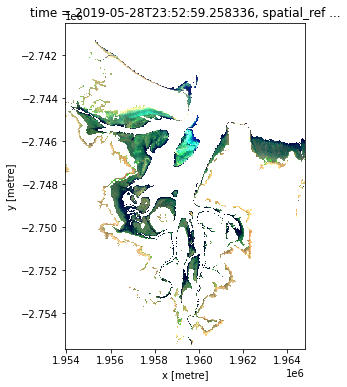

In [193]:
## Proof of concept: masking imagery based on ITEM extents

rgb(
    merged.where((merged.isel(time=0).relative > 0) & (merged.isel(time=0).relative < 9)),    
#     bands=['nbart_red', 'nbart_green', 'nbart_blue'], ## RGB
    bands=['nbart_swir_1', 'nbart_nir', 'nbart_green'], ## False colour
    index=1,
    index_dim='time',
    robust=True,
    percentile_stretch=None,
    col_wrap=4,
    size=6
   )

### Next steps:
- calculate some veg indices
- collate temporal stats
- plot statistical summaries 
    - do they highlight known areas of seagrass? 
    - Can any extra signals be determined such as seasonality or habitat migration?